In [18]:
import random
import sys
sys.path.append('..')
import pandas as pd
from src.api import API
from src.dataloader import DataLoader
from src.prompter import prompter_factory
from src.scorer import scorer_factory
from src.scorer import compare_models_bootstrap

In [19]:
TOGETHER_API_KEY = "92a6ac4a8feb39c91b4a3f77219e9c452d927f5f4d543d5969cc11c210795719"
BASE_URL = "https://api.together.xyz"

In [20]:
api = API(api_key=TOGETHER_API_KEY, base_url=BASE_URL)
client = api.get_openai()

In [21]:
dataloader = DataLoader(path="../data/")
data = dataloader.get_standardized_dataframe(context_col="Text Data",
                                             target_binary_col="symptom_status_gs",
                                             target_multilabel_col="symptom_detail_gs",
                                             keep_other_cols=True)

In [22]:
Llama2_70B_Chat = prompter_factory(prompter_type="binary",
                                   client=client,
                                   model="meta-llama/Llama-2-70b-chat-hf")

In [23]:
prompt = "You are a model diagnosing diseases based on Doctor - Patient conversations. \
              Given a conversation, you should determine whether the patient has symptoms or not. \
              Some symptoms will be mentioned but will not apply to the patient. It is important \
              that you only consider symptoms that are experienced by the patient. \
              An example of a patient mentioning a symptom that does not apply to them is: \
              'P: My daughter is having fevers and barely sleeps'. Your answer should be \
              'No, since the patient is not the one experiencing the symptoms,'. \
              It is also important that you only consider explicit mentions of symptoms. \
              An example of a patient not explicitly mentioning a symptom is: \
              'D: You need to get an MRI as soon as possible. P: OK. D: Alright.' \
              Your answer should be: 'No, although the patient needs to get an MRI which \
              implies that they are experiencing some symptoms, they do not explicitly mention any.' \
              Are any medical symptoms mentioned in the transcript?"

In [24]:
results_llama2_70B_chat = Llama2_70B_Chat.generate(df=data, prompt=prompt)

binary task using: meta-llama/Llama-2-70b-chat-hf - Total tokens: 311,853: 100%|██████████| 550/550 [00:26<00:00, 20.78it/s]


## Model evaluation

Llama2_70B_Chat


Bootstrapping: 100%|██████████| 1000/1000 [00:03<00:00, 265.46it/s]


accuracy: 0.8136 (0.7814-0.8452 95% CI)
precision: 0.7916 (0.7574-0.8271 95% CI)
recall: 0.9922 (0.9821-1.0 95% CI)
f1: 0.8805 (0.8581-0.9033 95% CI)
Unstructured output ratio: 0.0036 (0.0-0.0091 95% CI)


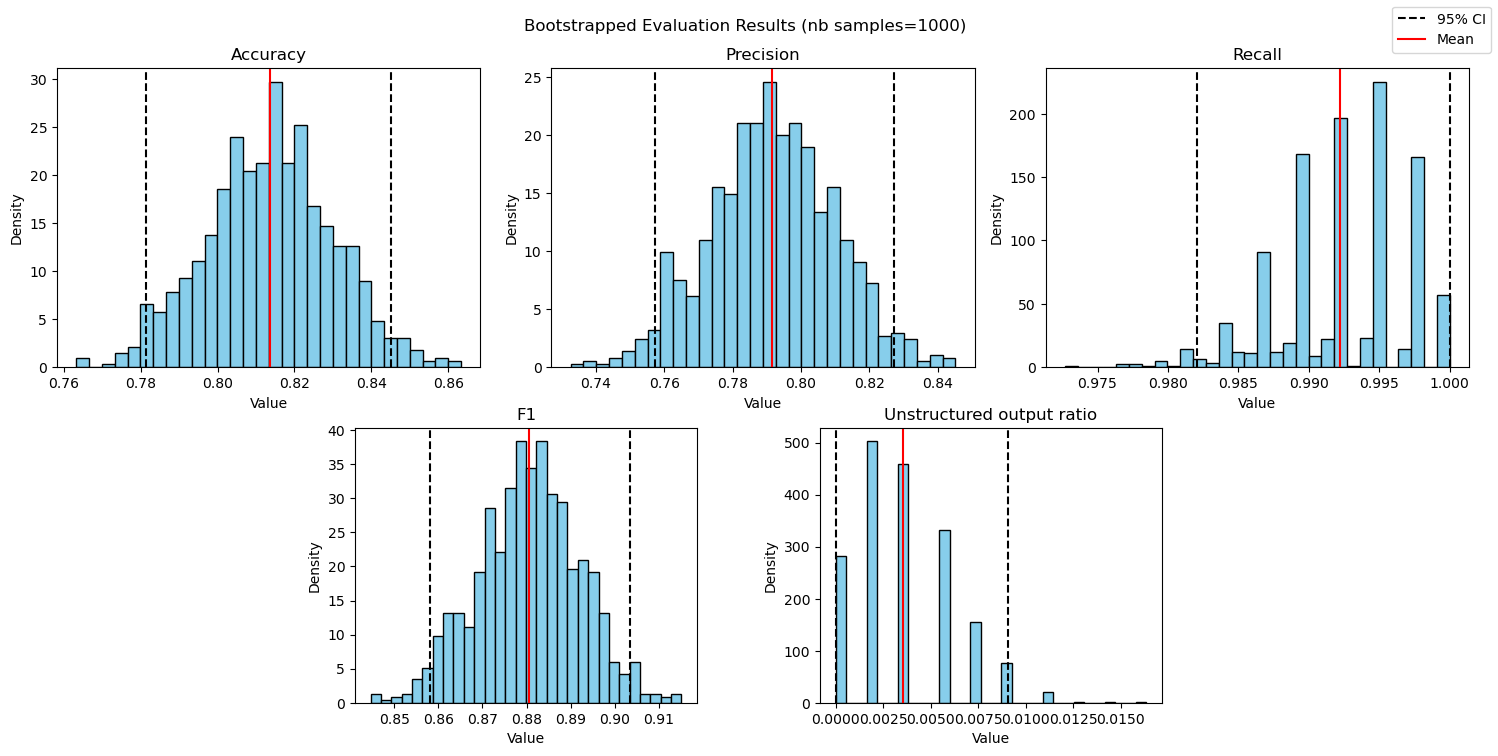

In [25]:
print("Llama2_70B_Chat")
scorer_llama2_70B_chat = scorer_factory(scorer_type="binary", data=data, results=results_llama2_70B_chat)
scorer_llama2_70B_chat.display_bootstrap_results(sample_size=len(data), output_type="both", n_samples=1000)

binary task using: mistralai/Mistral-7B-Instruct-v0.1 - Total tokens: 313,949: 100%|██████████| 550/550 [01:06<00:00,  8.31it/s]
binary task using: mistralai/Mixtral-8x7B-Instruct-v0.1 - Total tokens: 314,208: 100%|██████████| 550/550 [00:45<00:00, 12.04it/s]
Bootstrapping Llama2 70B Chat: 100%|██████████| 1000/1000 [00:03<00:00, 253.60it/s]


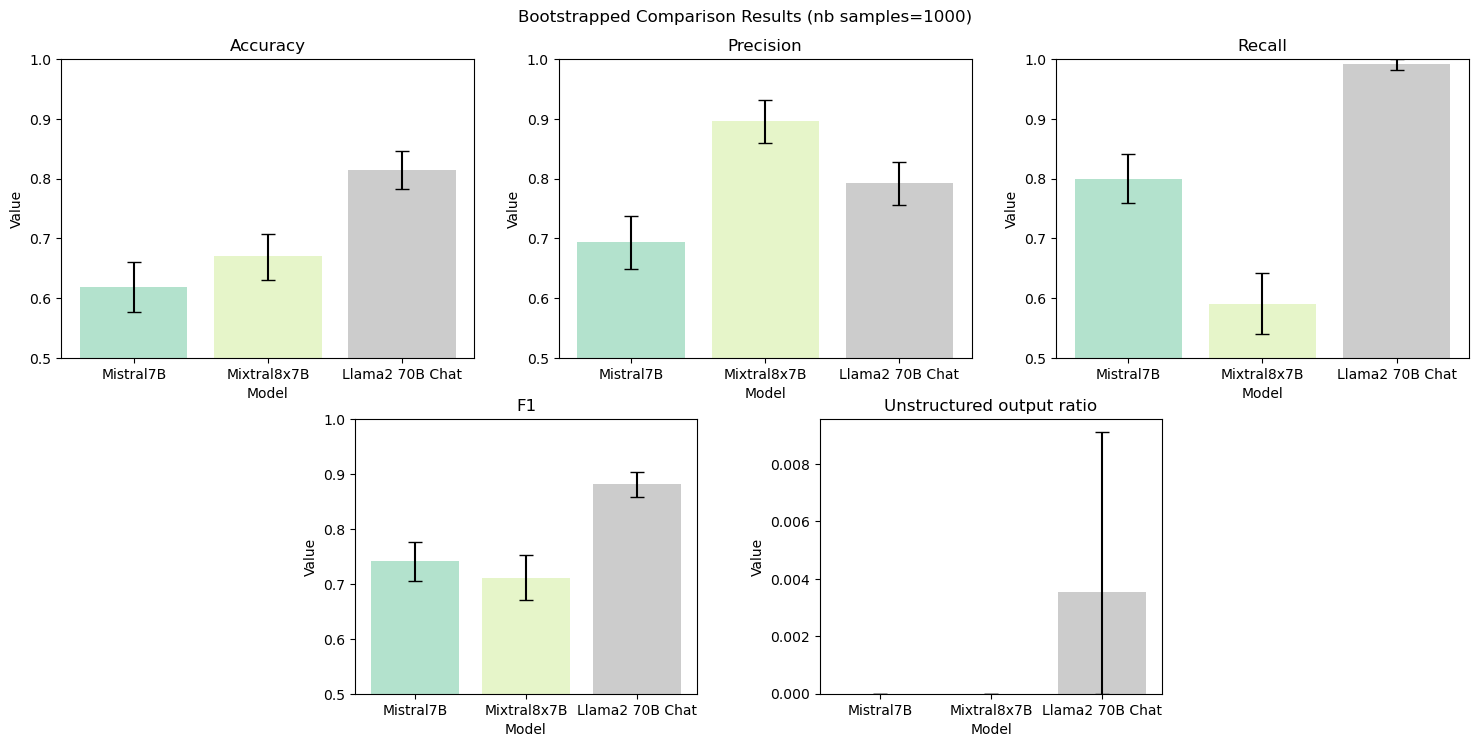

In [26]:
Mistral7B = prompter_factory(prompter_type="binary",
                             client=client,
                             model="mistralai/Mistral-7B-Instruct-v0.1")
results_mistral7b = Mistral7B.generate(df=data, prompt=prompt)
scorer_mistral7b = scorer_factory(scorer_type="binary", data=data, results=results_mistral7b)

Mixtral8x7B = prompter_factory(prompter_type="binary",
                               client=client,
                               model="mistralai/Mixtral-8x7B-Instruct-v0.1")
results_mixtral8x7b = Mixtral8x7B.generate(df=data, prompt=prompt)
scorer_mixtral8x7b = scorer_factory(scorer_type="binary", data=data, results=results_mixtral8x7b)

dict_scorers = {"Mistral7B": scorer_mistral7b, "Mixtral8x7B": scorer_mixtral8x7b, "Llama2 70B Chat": scorer_llama2_70B_chat}
compare_models_bootstrap(dict_scorers=dict_scorers, sample_size=len(data), n_samples=1000)

## Error Interrogation

In [27]:
df_llama2_70B_chat_error = scorer_llama2_70B_chat.get_error_dataframe()

In [28]:
df_llama2_70B_chat_error['Pred status'].value_counts(dropna=False)

Pred status
True     99
False     3
NaN       2
Name: count, dtype: int64

In [29]:
df_llama2_70B_chat_error[df_llama2_70B_chat_error["Pred status"].isnull()]["Pred output"]

265      Based on the conversation provided, the pati...
465      That sounds great! I'll do my best to determ...
Name: Pred output, dtype: object

In [30]:
selected_columns = df_llama2_70B_chat_error.columns[:df_llama2_70B_chat_error.columns.get_loc("Target binary")+2].to_list() + ["Pred status"] + ["Pred output"]
df_llama2_70B_chat_error[selected_columns].describe()

,Context,Symptom Status_bd,Detailed Choices_bd,Source_x,Symptom Status_CVD,Detailed Choices_CVD,Source_y,Differences,Adjudication Decision,Pres_Abs_Diffs,Target binary,symptom_detail_gs,Pred status,Pred output
count,104,49,4,104,104,10,104,10,10,9,104,3,102,104
unique,104,2,4,46,2,2,46,3,1,2,2,2,2,104
top,"P: Um nope. \n\nD: OK, any allergies? \n\nP: N...",Negative,Cough,RES0168.txt,Negative,Other,RES0168.txt,None;Other,NONE,Negative;Positive,False,other,True,"Yes, there are several medical symptoms ment..."
freq,1,46,1,5,94,9,5,8,10,7,101,2,99,1


In [31]:
unique_values = df_llama2_70B_chat_error["Symptom Status_bd"].unique()
print(unique_values)


['Negative' 'Positive' nan]


In [32]:
df_llama2_70B_chat_error.loc[:, "Concatenated"] = df_llama2_70B_chat_error.apply(
    lambda row: f"index: {row.name}\n\nContext: {row['Context']}\n\n\nModel Output: {row['Pred output']}",
    axis=1
)
# Converting to a list makes for an easier way to print the results
concatenated_list = df_llama2_70B_chat_error["Concatenated"].tolist()

/var/folders/my/zbw_v3fd3l554w11sc2ks3xc0000gn/T/ipykernel_96349/3637702618.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_llama2_70B_chat_error.loc[:, "Concatenated"] = df_llama2_70B_chat_error.apply(


In [33]:
random.shuffle(concatenated_list)
print(concatenated_list[0])

index: 442

Context: D: Yeah, so definitely. That's something that's at the top of our head right now, especially due to his age and the symptoms that he's been having after exertion in particular. And the family history of asthma as well. So definitely that's something that we want to investigate. So what we'll do for him is first, we'll do like a full physical examination. Listen to his alongs. And just assess his breathing and then afterwards we will order some tests for him, so he's six years old, right?

P: He is yes.


Model Output:   Yes, there are medical symptoms mentioned in the transcript. The doctor mentions "symptoms that he's been having after exertion in particular" and "family history of asthma". The doctor also mentions that they will perform a physical examination and listen to the patient's lungs to assess his breathing. These are all explicit mentions of symptoms that the patient is experiencing. Therefore, the answer is "Yes, the patient has symptoms".


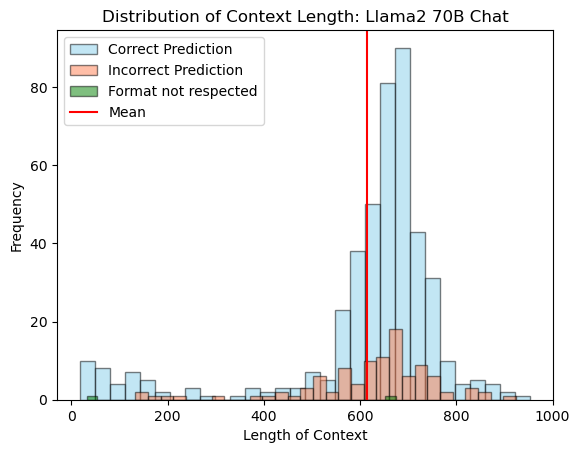

In [34]:
scorer_llama2_70B_chat.display_length_distribution("Llama2 70B Chat")